In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/wvs/wave7.csv")
df.head()

/var/folders/k9/j4977wt918z9ns7wk6kqfmqm0000gn/T/ipykernel_40504/977383760.py:1: DtypeWarning: Columns (582,583,584) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/wvs/wave7.csv")


,Unnamed: 0,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,...,victim_respondent_no,victim_family_no,war_no,baseline_security,security_neighborhood,security_financial,security_war,education,education_mother,education_father
0,0,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,36,AUS,900,AUL,...,1,1,0,0.666667,0.666667,1.000000,0.888889,3.0,4.0,2.0
1,1,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,36,AUS,900,AUL,...,1,1,1,1.000000,1.000000,1.000000,1.000000,7.0,6.0,6.0
2,2,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,36,AUS,900,AUL,...,1,1,1,0.666667,0.904762,0.500000,0.777778,7.0,6.0,7.0
3,3,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,36,AUS,900,AUL,...,1,1,1,0.666667,0.952381,0.666667,0.777778,4.0,3.0,3.0
4,4,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,36,AUS,900,AUL,...,1,1,0,0.666667,0.857143,1.000000,0.888889,7.0,2.0,3.0


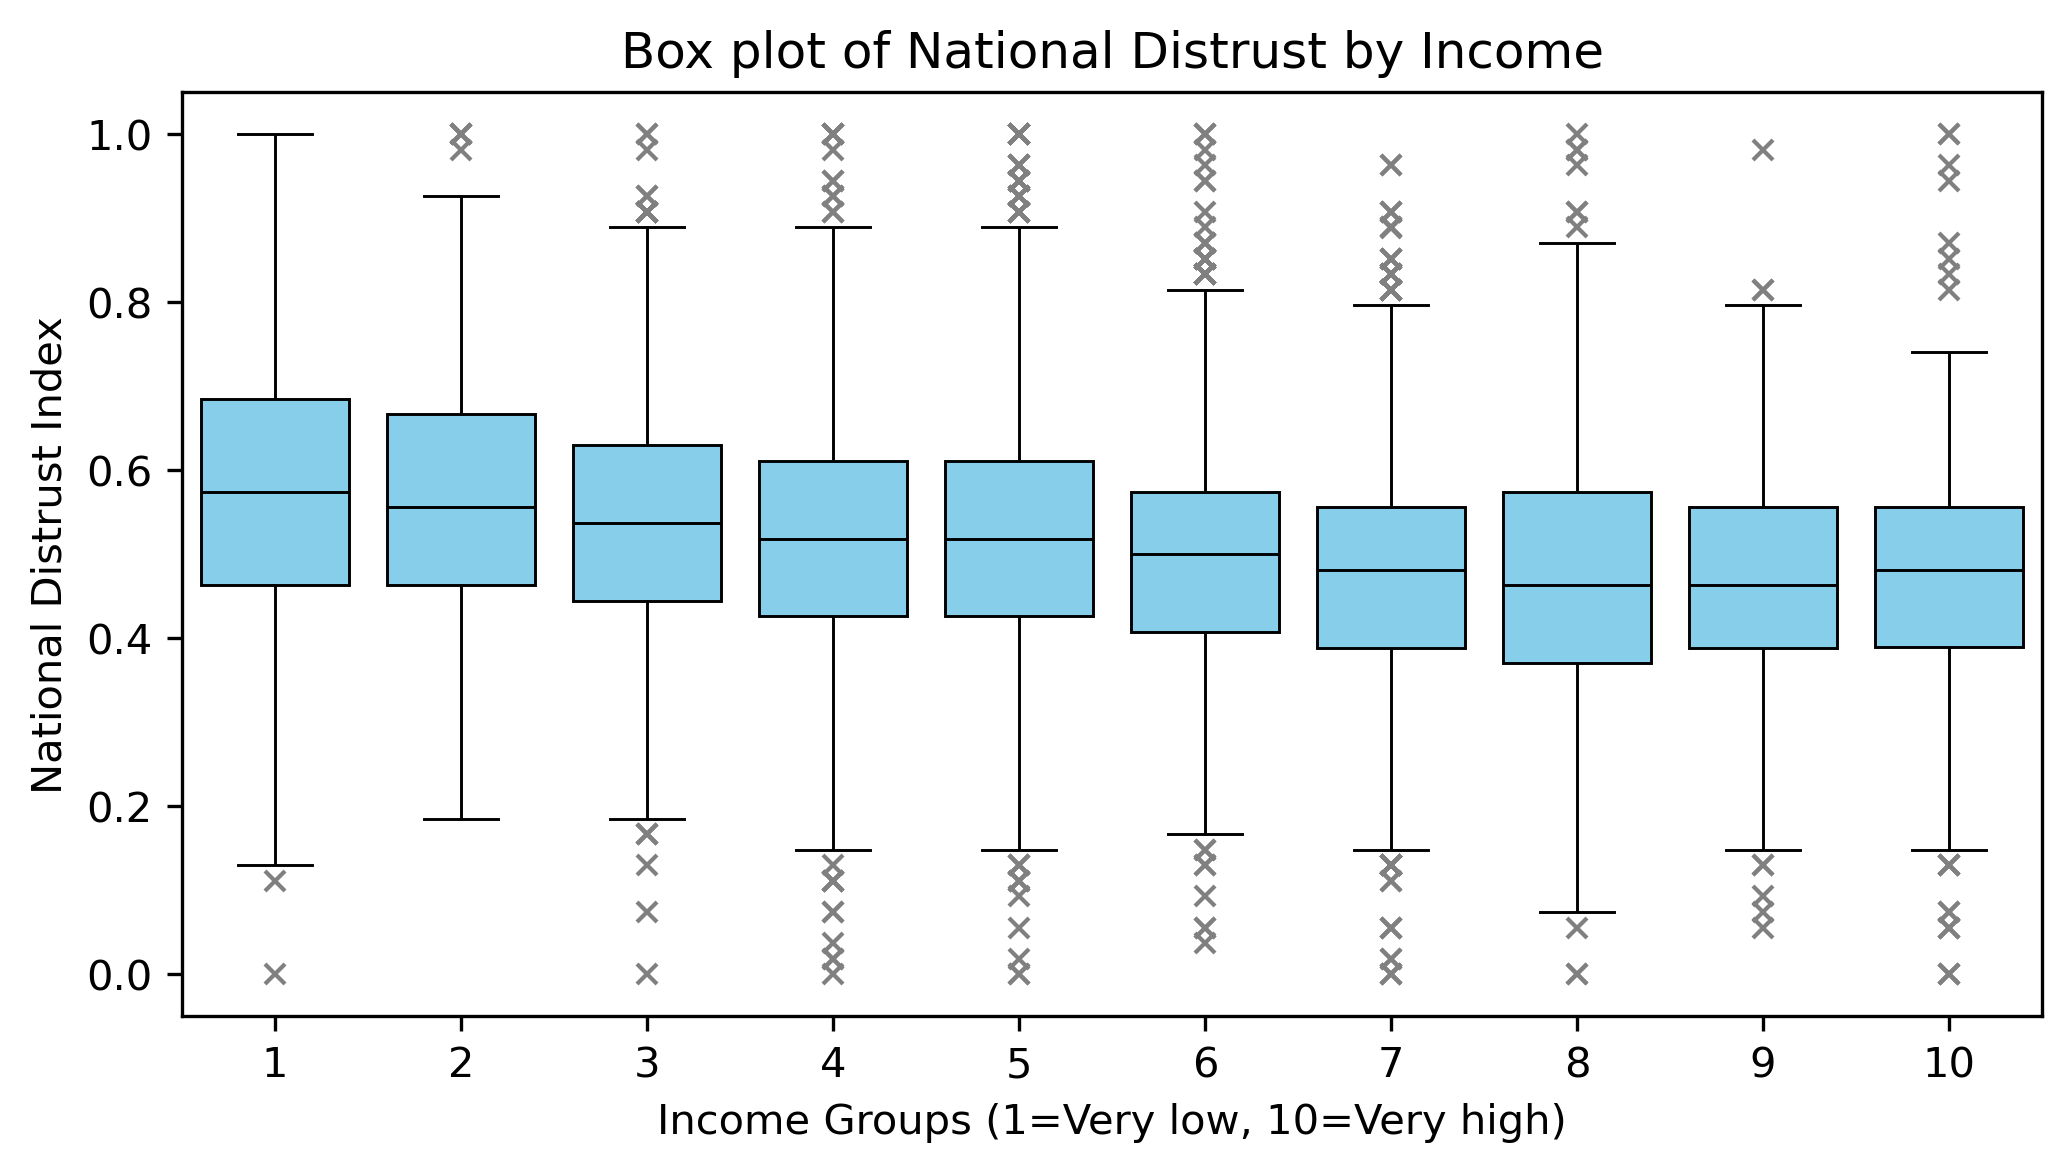

In [5]:
plt.figure(figsize=(8,4), dpi=300)
plt.rcParams["font.family"] = "sans-serif"
flierprops = dict(marker='x', markersize=5, markeredgecolor='gray')
sns.boxplot(data=df, x="Q288", y="national_distrust_index", saturation=1 , color="skyblue", flierprops=flierprops, linewidth=.7,
            linecolor="black")
plt.xlabel("Income Groups (1=Very low, 10=Very high)")
plt.ylabel("National Distrust Index")
plt.title("Box plot of National Distrust by Income")
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler

tf = pd.read_csv("./data/wvs/WVS_Time_Series.csv").query("COUNTRY_ALPHA in 'DEU'")

# copying and slightly modifying the attach distrust index function from our utils 
def attach_national_distrust_index(df: pd.DataFrame) -> pd.DataFrame:
  national_trust_questions = ["E069_12", "E069_10", "E069_04", "E069_02", "E069_05", "E069_06", "E069_07", "E069_08", "E069_11", "E069_17"]

  result = df.copy()

  # 1. imputing with median --------------------------------------------
  # create a median dict with all the relevant values
  median_dict = {}
  countries = result.COUNTRY_ALPHA.unique()

  for ct in countries:
      median_dict[ct] = {}

  for tq in national_trust_questions:
      for ct in countries:
          median_dict[ct][tq] = result.loc[(result[tq] > 0) & (result.COUNTRY_ALPHA == ct), tq].median()
  
  # now populate the dataframe with the median values
  for tq in national_trust_questions:
      result[tq] = result.loc[:, [tq, "COUNTRY_ALPHA"]].apply(lambda row: median_dict[row["COUNTRY_ALPHA"]][tq] if row[tq] <= 0 else row[tq], axis=1)
    
  # 2. Minmax scaling --------------------------------------------
  scaler = MinMaxScaler()
  scaler.fit(result.loc[:, national_trust_questions])
  result.loc[:, national_trust_questions] = scaler.transform(result.loc[:, national_trust_questions])

  # 3. Creating trust indeces by rowwise mean --------------------------------------------
  result["national_distrust_index"] = result.loc[:, national_trust_questions].mean(axis=1)
  
  return result

tf = attach_national_distrust_index(tf)

In [4]:
tf.rename(columns={"S002VS": "wave"}, inplace=True)

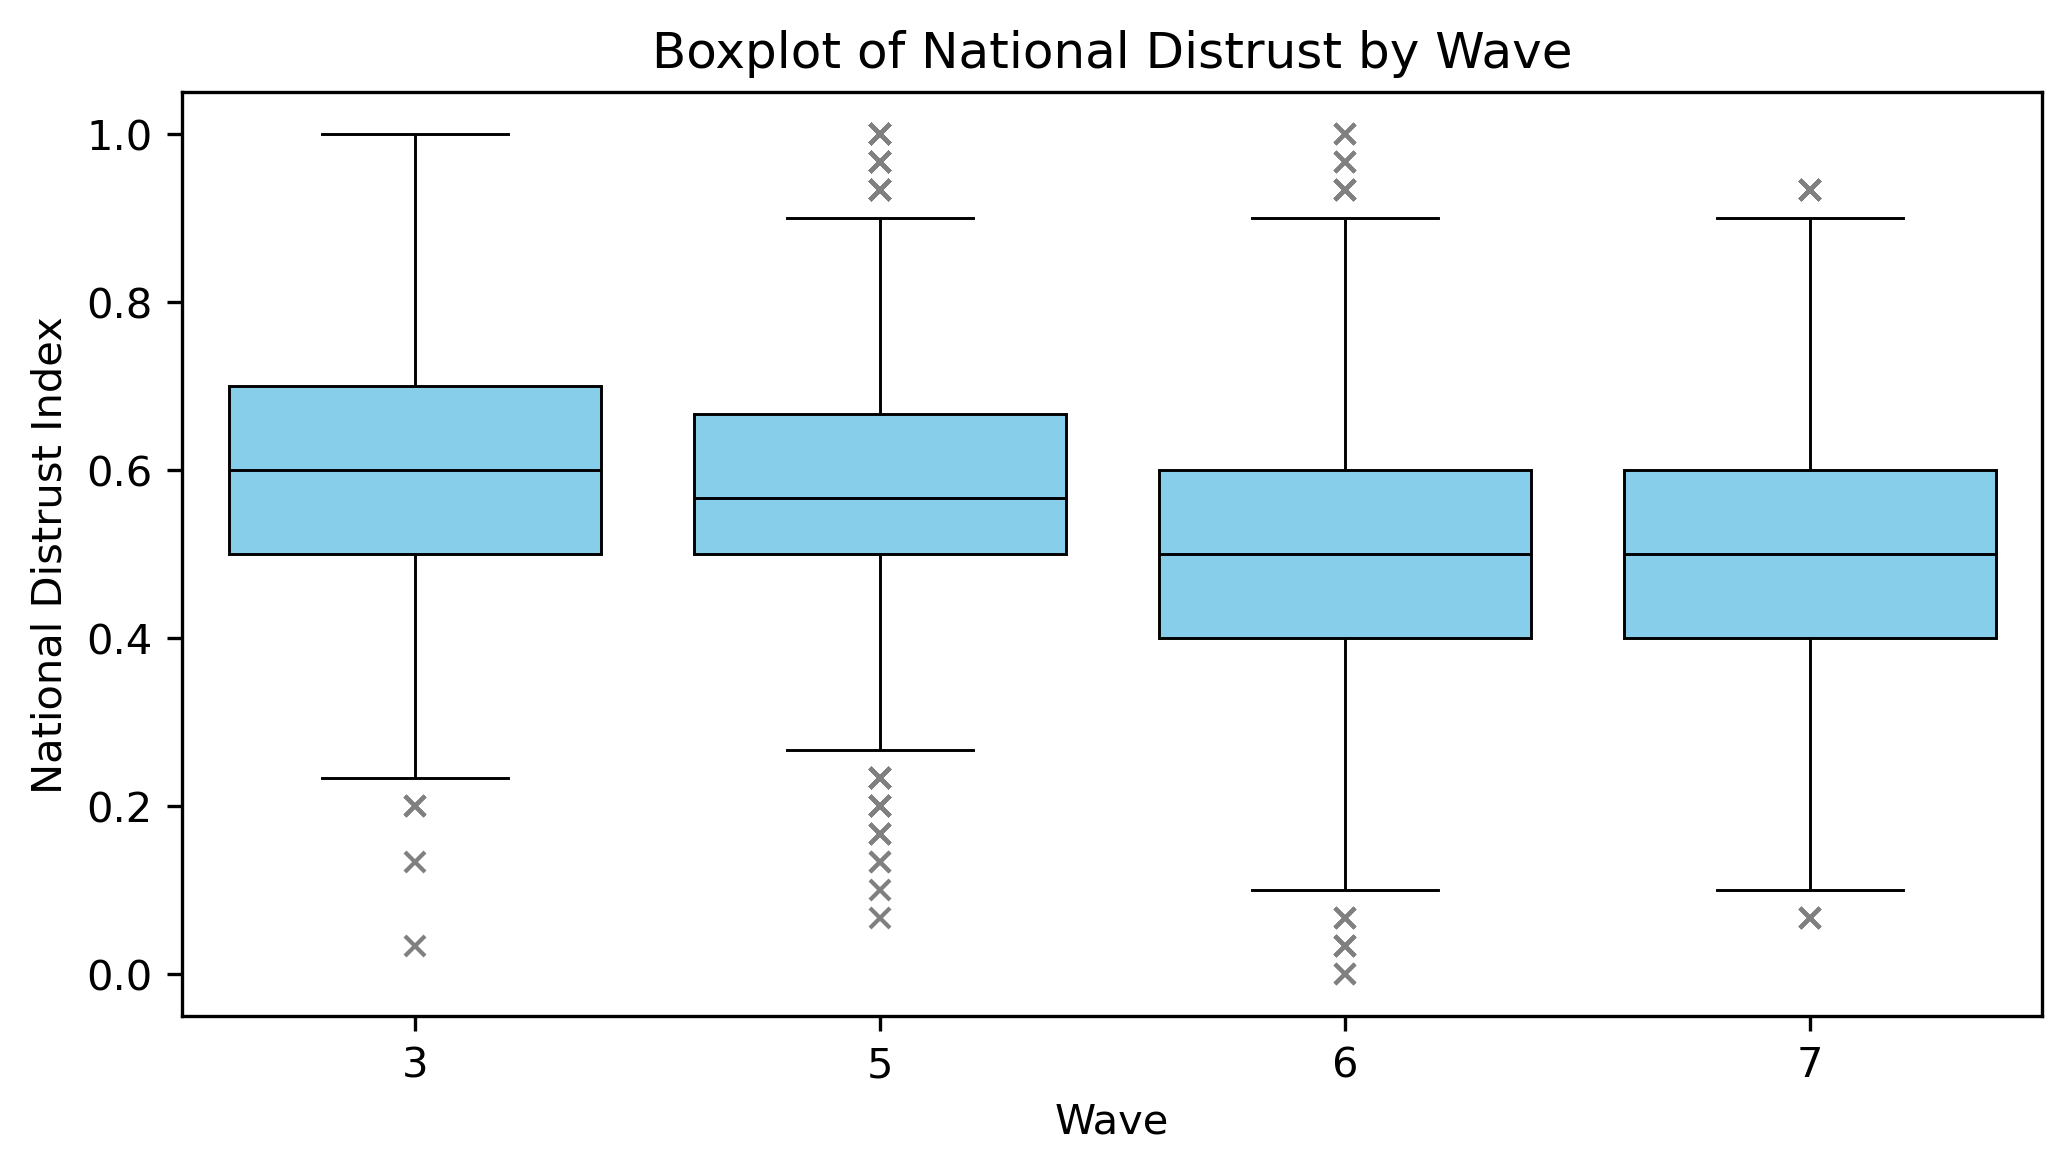

In [6]:
plt.figure(figsize=(8,4), dpi=300)
plt.rcParams["font.family"] = "sans-serif"
flierprops = dict(marker='x', markersize=5, markeredgecolor='gray')
sns.boxplot(data=tf, x="wave", y="national_distrust_index", saturation=1 , color="skyblue", flierprops=flierprops, linewidth=.7,
            linecolor="black")
plt.xlabel("Wave")
plt.ylabel("National Distrust Index")
plt.title("Boxplot of National Distrust by Wave")
plt.show()

In [41]:
tf[["wave", "national_distrust_index"]].to_csv("./data/wvs/time_series_trust.csv")